## Summary
In this notebook, the paired data from the Nocardia dataset is analysed for the NPClassScore paper. This data originates from MSV000084771.

The newly developed implementation of NPClassScore is used in combination with Metcalf scoring to discover BGC-MS/MS spectrum links in the Nocardia dataset. Validated links from the PoDP are used to validate the results.

Sections:
- Loading the MSV000084771 dataset
- Scoring using the new NPClassScore method
- Investigating NPClassScore cutoff
- Counting number of links
- Making plots showing the filtered links
- Investigate known links

## Loading MSV000084771 dataset

In [299]:
import sys, csv, os
# if running from clone of the git repo
sys.path.append('../../src')

# import the main NPLinker class. normally this all that's required to work
# with NPLinker in a notebook environment
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nplinker.nplinker import NPLinker
from nplinker.nplinker import Spectrum
from collections import Counter, defaultdict

In [4]:
# load local crusemann data
npl = NPLinker(
    {'dataset':
     {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/'},
    'docker':
     {'run_canopus': True}})
npl.load_data()

13:31:40 [INFO] config.py:121, Loading from local data in directory /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/
13:31:40 [WARNING] loader.py:50, WARNING: unable to find extra_nodes_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/quantification_table_reformatted/*.csv"
13:31:40 [WARNING] loader.py:50, WARNING: unable to find metadata_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/metadata_table/metadata_table*.txt"
13:31:40 [WARNING] loader.py:50, WARNING: unable to find quantification_table_file in path "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/quantification_table/quantification_table*.csv"
13:31:40 [INFO] loader.py:84, Trying to discover correct bigscape directory under /mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data

True

In [5]:
# del NPLinker

In [6]:
# Basic functionality
# ===================
#
# Once you have an NPLinker object with all data loaded, there are a collection of simple
# methods and properties you can use to access objects and metadata. Some examples are 
# given below, see https://nplinker.readthedocs.io/en/latest/ for a complete API description.

# configuration/dataset metadata
# - a copy of the configuration as parsed from the .toml file (dict)
print(npl.config) 
# - the path to the directory where various nplinker data files are located (e.g. the 
#   default configuration file template) (str)
print(npl.data_dir)
# - a dataset ID, derived from the path for local datasets or the paired platform ID
#   for datasets loaded from that source (str)
print(npl.dataset_id)
# - the root directory for the current dataset (str)
print(npl.root_dir)

# objects
# - you can directly access lists of each of the 4 object types:
print('BGCs:', len(npl.bgcs))
print('GCFs:', len(npl.gcfs)) # contains GCF objects
spectra_in_dataset = [spec for spec in npl.spectra if 'strains=0' not in str(spec)]
print('Spectra:', len(npl.spectra), # contains Spectrum objects
      '({} spectra actually present in currently selected strains in strain_mappings.csv)'.format(len(spectra_in_dataset)))
print('Molecular Families:', len(npl.molfams)) # contains MolecularFamily objects

{'loglevel': 'INFO', 'logfile': '', 'log_to_stdout': True, 'repro_file': '', 'dataset': {'root': '/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/', 'overrides': {}, 'platform_id': ''}, 'antismash': {'antismash_format': 'default', 'ignore_spaces': False}, 'docker': {'run_bigscape': True, 'extra_bigscape_parameters': '', 'run_canopus': True}, 'webapp': {'tables_metcalf_threshold': 2.0}, 'scoring': {'rosetta': {}}}
../../src/nplinker/data

/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/nplinker_data/pairedomics/extracted/MSV000084771/
BGCs: 367
GCFs: 300
Spectra: 11464 (3080 spectra actually present in currently selected strains in strain_mappings.csv)
Molecular Families: 10458


In [7]:
# Count spectra with chemical class info
spectra_in_dataset_with_class = []
spectra_in_dataset_no_class = []
for spec in spectra_in_dataset:
    spec_can = npl.chem_classes.canopus.spectra_classes.get(str(spec.spectrum_id))
    if not spec_can:
        spec_mne = npl.chem_classes.molnetenhancer.spectra_classes(str(spec.spectrum_id))
        if not spec_mne:
            spectra_in_dataset_no_class.append(spec)
        else:
            spectra_in_dataset_with_class.append(spec)
    else:
        spectra_in_dataset_with_class.append(spec)
print(f"From the {len(spectra_in_dataset)} spectra present in current strains, {len(spectra_in_dataset_with_class)} spectra have class info")

From the 3080 spectra present in current strains, 2271 spectra have class info


In [8]:
parent_masses = [spec.parent_mz for spec in spectra_in_dataset]

(array([ 65., 350., 346., 401., 907., 444., 251.,  92.,  19.,  40.,  37.,
          9.,  10.,  20.,  23.,   4.,   9.,   6.,   1.,  46.]),
 array([ 132.02672355,  263.45046573,  394.8742079 ,  526.29795008,
         657.72169226,  789.14543444,  920.56917661, 1051.99291879,
        1183.41666097, 1314.84040314, 1446.26414532, 1577.6878875 ,
        1709.11162968, 1840.53537185, 1971.95911403, 2103.38285621,
        2234.80659839, 2366.23034056, 2497.65408274, 2629.07782492,
        2760.5015671 ]),
 <BarContainer object of 20 artists>)

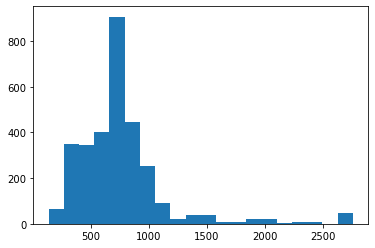

In [9]:
plt.hist(parent_masses, bins=20)

In [10]:
parent_masses_no_pred = [spec.parent_mz for spec in spectra_in_dataset_no_class]

(array([ 14.,  81.,  82.,  75.,  87.,  52., 197.,  65.,  18.,  27.,  34.,
          2.,   4.,   9.,  10.,   1.,   8.,   3.,   1.,  39.]),
 array([ 132.02672355,  263.45046573,  394.8742079 ,  526.29795008,
         657.72169226,  789.14543444,  920.56917661, 1051.99291879,
        1183.41666097, 1314.84040314, 1446.26414532, 1577.6878875 ,
        1709.11162968, 1840.53537185, 1971.95911403, 2103.38285621,
        2234.80659839, 2366.23034056, 2497.65408274, 2629.07782492,
        2760.5015671 ]),
 <BarContainer object of 20 artists>)

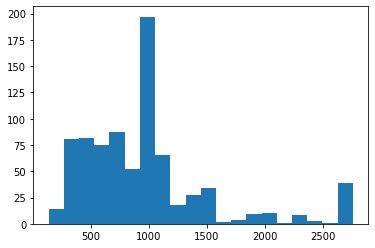

In [11]:
plt.hist(parent_masses_no_pred, bins=20)

## Scoring using the new NPClassScore method
Use the scoring methods in NPLinker to find links with:
- Metcalf scoring
- Metcalf + NPClassScore scoring

In [302]:
mc = npl.scoring_method('metcalf')

# Now mc is an instance of the class that implements Metcalf scoring. Once
# you have such an instance, you may change any of the parameters it exposes.
# In the case of Metcalf scoring, the following parameters are currently exposed:
# - cutoff (float): the scoring threshold. Links with scores less than this are excluded
# - standardised (bool): set to True to use standardised scores (default), False for regular
mc.cutoff = 2.5
mc.standardised = True

results = npl.get_links(npl.gcfs, mc, and_mode=True)

# get_links returns an instance of a class called LinkCollection. This provides a wrapper
# around the results of the scoring operation and has various useful properties/methods:
#
# - len(results) or .source_count will tell you how many of the input_objects were found to have links
print('Number of results: {}'.format(len(results)))
# - .sources is a list of those objects
objects_with_links = results.sources
# - .links is a dict with structure {input_object: {linked_object: ObjectLink}} 
objects_and_link_info = results.links
# - .get_all_targets() will return a flat list of *all* the linked objects (for all sources)
all_targets = results.get_all_targets() 
# - .methods is a list of the scoring methods passed to get_links
methods = results.methods

Number of results: 298


In [303]:
# Initialise NPClassScore scoring the same way
# default method: 'mix' meaning use both CANOPUS and MolNetEnhancer with priority to CANOPUS
npcl = npl.scoring_method('npclassscore')
npcl.cutoff = 0.25

# Now only links are kept that pass the cutoff for both methods
results_both = npl.get_links(npl.gcfs, [mc, npcl], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_both)))
print(results_both.methods)

08:50:08 [INFO] methods.py:982, Running NPClassScore...
08:50:08 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
08:50:16 [INFO] methods.py:1003, Calculating NPClassScore for 300 objects to 11464 targets (123323 pairwise interactions that share at least 1 strain). This might take a while.
08:50:25 [WARNING] methods.py:1047, 809 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
08:50:25 [INFO] methods.py:1052, NPClassScore completed in 17.2s
Number of results for Metcalf and NPClassScore scoring: 275
{<nplinker.scoring.methods.MetcalfScoring object at 0x7efb3a67e048>, <nplinker.scoring.methods.NPClassScoring object at 0x7efb375121d0>}


In [304]:
# Also create an object with both Metcalf and NPClassScore with a cutoff of 0 to investigate proper cutoff
npcl_0 = npl.scoring_method('npclassscore')
npcl_0.cutoff = 0

# Now only links are kept that pass the cutoff for both methods
results_0 = npl.get_links(npl.gcfs, [mc, npcl_0], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_0)))
print(results_0.methods)

08:50:35 [INFO] methods.py:982, Running NPClassScore...
08:50:36 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
08:50:44 [INFO] methods.py:1003, Calculating NPClassScore for 300 objects to 11464 targets (123323 pairwise interactions that share at least 1 strain). This might take a while.
08:50:53 [WARNING] methods.py:1047, 809 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
08:50:53 [INFO] methods.py:1052, NPClassScore completed in 17.2s
Number of results for Metcalf and NPClassScore scoring: 282
{<nplinker.scoring.methods.MetcalfScoring object at 0x7efb3a67e048>, <nplinker.scoring.methods.NPClassScoring object at 0x7efb363b7358>}


In [305]:
# score just with NPClassScore to check if missing known links have good scores

npcl_only = npl.scoring_method('npclassscore')
npcl_only.cutoff = 0

results_npcl = npl.get_links(npl.gcfs, [npcl_only], and_mode=True)

print('Number of results for NPClassScore scoring: {}'.format(len(results_npcl)))
print(results_npcl.methods)

08:50:54 [INFO] methods.py:982, Running NPClassScore...
08:50:54 [INFO] methods.py:996, Using Metcalf scoring to get shared strains
08:51:01 [INFO] methods.py:1003, Calculating NPClassScore for 300 objects to 11464 targets (123323 pairwise interactions that share at least 1 strain). This might take a while.
08:51:11 [WARNING] methods.py:1047, 809 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
08:51:11 [INFO] methods.py:1052, NPClassScore completed in 16.8s
Number of results for NPClassScore scoring: 300
{<nplinker.scoring.methods.NPClassScoring object at 0x7efb45735a20>}


## Investigating NPClassScore cutoff
We choose 0.25 as a cutoff as around this value there is a marked drop in the number of links per GCF.

In [306]:
# gradient of class linking score cutoff

cs_cutoffs = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
d_all_num_links = []
d_all_num_filtered_links = {cut: [] for cut in cs_cutoffs}
d_all_no_scores = []
count_nones = False  # this controls if you want to include spectra without class info like npcl.filter_missing_scores

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum) and 'strains=0' not in str(link_data.target)])
    
    # loop through cutoffs
    for cs_cut in cs_cutoffs:
        num_filtered_links = 0
        if gcf in results_0.links:
            # calculate number of links with npcl filtering
            filtered_links = []
            for link_data in results_0.get_sorted_links(mc, gcf):
                if isinstance(link_data.target, Spectrum):
                    npcl_score = npcl_0.format_data(link_data[npcl_0])
                    if npcl_score:
                        if float(npcl_score) > cs_cut:
                            filtered_links.append(link_data)
                    else:
                        if count_nones:
                            filtered_links.append(link_data)
            num_filtered_links = len(filtered_links)
        d_all_num_filtered_links[cs_cut].append(num_filtered_links)
    d_all_num_links.append(num_links)

In [307]:
print(f"NPClassScore_cutoff\tNumber_of_links\tChange")
print(f"0\t{np.mean(d_all_num_links):.2f}")
for cs_cut, filt_links in d_all_num_filtered_links.items():
    print(f"{cs_cut}\t{np.mean(filt_links):.2f}\t{(np.mean(filt_links)-np.mean(d_all_num_links))/np.mean(d_all_num_links):.2f}")

NPClassScore_cutoff	Number_of_links	Change
0	206.33
0.125	98.27	-0.52
0.25	64.35	-0.69
0.375	58.24	-0.72
0.5	45.85	-0.78
0.625	35.17	-0.83
0.75	13.03	-0.94
0.875	6.31	-0.97


## Counting number of links
For each GCF count the number of links with and without NPClassScore filtering using the chosen cutoff of 0.25.

In [17]:
# loop through all gcfs (objects) and count how many links exist (spectra)
all_num_links = []
all_num_filtered_links = []
all_no_scores = []
count_nones = False  # this controls if you want to include spectra without class info like npcl.filter_missing_scores

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    num_filtered_links = 0
    if gcf in results_both.links:
        if count_nones:
            num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum)])
        else:
            num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum) if link_data[npcl]])
    all_num_links.append(num_links)
    all_num_filtered_links.append(num_filtered_links)

np.mean(all_num_links), np.mean(all_num_filtered_links)

(206.32666666666665, 64.34666666666666)

In [18]:
# change in average links per GCF
(np.mean(all_num_filtered_links)-np.mean(all_num_links))/np.mean(all_num_links)

-0.6881320882742576

## Making plots showing the filtered links

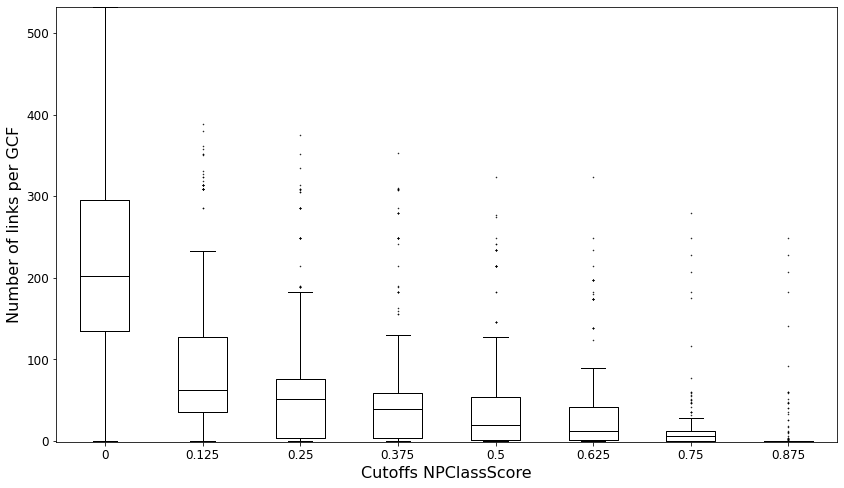

In [315]:
sorted_filt_items = sorted(d_all_num_filtered_links.items())
labels = ["0"] + [f"{cut}" for cut, vals in sorted_filt_items]
xs = [d_all_num_links] + [vals for keys, vals in sorted_filt_items]
lg_size = 14
custom_xlim = (-1, max(d_all_num_links))
links_title = "Number of links per GCF"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.boxplot(xs, labels=labels, flierprops={"markersize": 0.5}, medianprops={"color": "black"})
plt.setp(ax, ylim=custom_xlim, xlabel="Cutoffs NPClassScore", ylabel=links_title)
figout = "/home/louwe015/NPLinker/boxplot_cutoffs_MSV000084771_npclass_mix_can-mne_figure.svg"
plt.savefig(figout)

Use MNE when there is no CANOPUS prediction
Bin size: 25


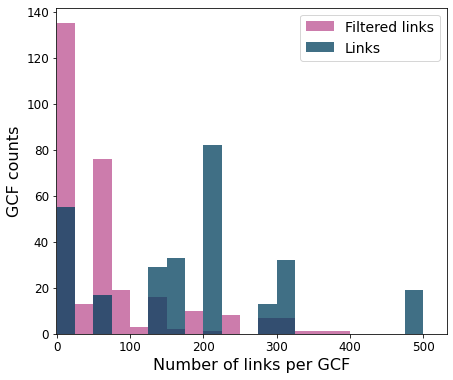

In [314]:
print("Use MNE when there is no CANOPUS prediction")
labels = ["Links", "Filtered links"]
colours = ["#003f5c", "#bc5090", "#ffa600"]
xs = [all_num_links, all_num_filtered_links]
lg_size = 14
custom_xlim = (-1, max(d_all_num_links))
bin_size = 25
print("Bin size:", bin_size)
n_bins = np.arange(0, max(d_all_num_links), bin_size)
links_title = "Number of links per GCF"
count_title = "GCF counts"
hist_type = "stepfilled"
alpha = 0.75

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
ax0.hist(xs[:2], bins=n_bins, density=False, histtype=hist_type, stacked=False, label=labels[:2],
         color=colours[:2], alpha=alpha)
ax0.legend(prop={'size': lg_size})
plt.setp(ax0, xlim=custom_xlim, xlabel=links_title, ylabel=count_title)
figout = "/home/louwe015/NPLinker/filtered_links_MSV000084771_mix_can-mne_figure_new.svg"
plt.savefig(figout)

In [313]:
# save xs
xs_out = '/home/louwe015/NPLinker/filtered_data_MSV000084771.pickle'
pickle.dump(xs, open(xs_out, 'wb'))

## Investigate known links

In [301]:
# To find some of the known links, the metcalf threshold had to be lowered to 2:
mc.cutoff

2

In [181]:
# Nocobactin hits with cblaster
# NC_016887.1.region003
# NZ_BAFR01000032.region001
# NZ_BAGG01000019.region002
# NZ_LMFE01000007.region002
# NZ_BDAX01000006.region001
# NZ_BDBF01000011.region001
# NZ_BDBM01000018.region001
# NZ_BDBU01000023.region001
# NZ_BDCA01000029.region001
# NZ_BDCL01000038.region001
# NZ_BDCU01000023.region001
nocobactin_hits = ['NC_016887.1.region003','NZ_BAFR01000032.region001','NZ_BAGG01000019.region002','NZ_LMFE01000007.region002','NZ_BDAX01000006.region001','NZ_BDBF01000011.region001','NZ_BDBM01000018.region001','NZ_BDBU01000023.region001','NZ_BDCA01000029.region001','NZ_BDCL01000038.region001','NZ_BDCU01000023.region001']

In [182]:
nocobactin_hits_bgcs = [bgc for bgc in npl.bgcs if bgc.name in nocobactin_hits]
nocobactin_hits_bgcs

[BGC(id=1, name=NC_016887.1.region003, strain=Strain(Nocardia cyriacigeorgica GUH-2) [4 aliases], asid=NC_016887.1, region=3),
 BGC(id=10, name=NZ_BAFR01000032.region001, strain=Strain(Nocardia araoensis NBRC 100135) [46 aliases], asid=NZ_BAFR01000032, region=1),
 BGC(id=30, name=NZ_BAGG01000019.region002, strain=Strain(Nocardia takedensis NBRC 100417) [37 aliases], asid=NZ_BAGG01000019, region=2),
 BGC(id=31, name=NZ_BDBM01000018.region001, strain=Strain(Nocardia gamkensis NBRC 108242) [29 aliases], asid=NZ_BDBM01000018, region=1),
 BGC(id=63, name=NZ_BDBF01000011.region001, strain=Strain(Nocardia elegans NBRC 108235) [32 aliases], asid=NZ_BDBF01000011, region=1),
 BGC(id=99, name=NZ_BDBU01000023.region001, strain=Strain(Nocardia jejuensis NBRC 103114) [27 aliases], asid=NZ_BDBU01000023, region=1),
 BGC(id=113, name=NZ_BDCA01000029.region001, strain=Strain(Nocardia vermiculata NBRC 100427) [21 aliases], asid=NZ_BDCA01000029, region=1),
 BGC(id=122, name=NZ_BDCL01000038.region001, stra

In [183]:
known_links_dict = {}

### Mycobactin-like

In [328]:
# nocobactin hit with cblaster found in Nocardia araoensis NBRC 100135
name_hit = 'mycobactin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [8614]  # as listed in publication https://journals.asm.org/doi/full/10.1128/mSystems.00125-20 based on parent mass 840.3669

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BAFR01000032.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=10, name=NZ_BAFR01000032.region001, strain=Strain(Nocardia araoensis NBRC 100135) [46 aliases], asid=NZ_BAFR01000032, region=1)]
{GCF(id=10, class=NRPS, gcf_id=25, strains=1)} 1


In [329]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 10][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=10, class=NRPS, gcf_id=25, strains=1),
 StrainCollection(n=1) [Nocardia araoensis NBRC 100135],
 {BGC(id=10, name=NZ_BAFR01000032.region001, strain=Strain(Nocardia araoensis NBRC 100135) [46 aliases], asid=NZ_BAFR01000032, region=1)})

In [330]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = len(result_links_both)
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=10, class=NRPS, gcf_id=25, strains=1), 135 total links, 1 methods used
Rank above cutoff (original rank)
1.(2)	Spectrum(id=10, spectrum_id=11, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.4435483870967742, 'mibig_classes', 'cf_class', 'NRP', 'Carboxylic acids and derivatives')
Precursor_mz: 205.105
1.(2)	Spectrum(id=12, spectrum_id=13, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 205.112
1.(2)	Spectrum(id=54, spectrum_id=55, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 255.101
1.(2)	Spectrum(id=103, spectrum_id=104, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.4435483870967742, 'mibig_classes', 'cf_class', 'NRP', 'Carboxylic acids and derivatives')
Precursor_mz: 282.27802
1.(2)	Spec

In [331]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

221 90


### Mycobactin-like (2)

In [247]:
# nocobactin hit with cblaster found in Nocardia takedensis NBRC 100417: NZ_BAGG01000019.region002
name_hit = 'mycobactin takedensis'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [8612]  # as listed in publication https://journals.asm.org/doi/full/10.1128/mSystems.00125-20 based on parent mass 840.3669

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BAGG01000019.region002"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=30, name=NZ_BAGG01000019.region002, strain=Strain(Nocardia takedensis NBRC 100417) [37 aliases], asid=NZ_BAGG01000019, region=2)]
{GCF(id=28, class=NRPS, gcf_id=73, strains=2)} 1


In [248]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 28][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=28, class=NRPS, gcf_id=73, strains=2),
 StrainCollection(n=2) [Nocardia takedensis NBRC 100417,Nocardia gamkensis NBRC 108242],
 {BGC(id=30, name=NZ_BAGG01000019.region002, strain=Strain(Nocardia takedensis NBRC 100417) [37 aliases], asid=NZ_BAGG01000019, region=2),
  BGC(id=31, name=NZ_BDBM01000018.region001, strain=Strain(Nocardia gamkensis NBRC 108242) [29 aliases], asid=NZ_BDBM01000018, region=1)})

In [249]:
cutoff = 0.25
result_links_mc = results.get_sorted_links(mc, result_gcf)
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=28, class=NRPS, gcf_id=73, strains=2), 498 total links, 1 methods used
Rank above cutoff (original rank)
1.(4)	Spectrum(id=26, spectrum_id=27, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 222.076
1.(4)	Spectrum(id=224, spectrum_id=225, strains=1)	metcalf=2.1213	shared strains=1	MF=136
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 311.151
1.(4)	Spectrum(id=235, spectrum_id=236, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.29936974789915966, 'as_classes', 'npc_pathway', 'NRPS', 'Polyketides')
Precursor_mz: 313.14401
1.(4)	Spectrum(id=269, spectrum_id=270, strains=1)	metcalf=2.1213	shared strains=1	MF=59
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 320.186
1.(4)	Spectrum(id=360, spectr

1.(4)	Spectrum(id=4329, spectrum_id=4330, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 657.45502
1.(4)	Spectrum(id=4403, spectrum_id=4404, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 663.50403
1.(4)	Spectrum(id=4523, spectrum_id=4524, strains=1)	metcalf=2.1213	shared strains=1	MF=312
NPClassScore: (0.4583333333333333, 'mibig_classes', 'cf_subclass', 'NRP', 'Amino acids, peptides, and analogues')
Precursor_mz: 669.41998
1.(4)	Spectrum(id=4528, spectrum_id=4529, strains=1)	metcalf=2.1213	shared strains=1	MF=70
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 671.27002
1.(4)	Spectrum(id=4538, spectrum_id=4539, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 

NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 796.38898
1.(4)	Spectrum(id=5799, spectrum_id=5800, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.4583333333333333, 'mibig_classes', 'cf_subclass', 'NRP', 'Amino acids, peptides, and analogues')
Precursor_mz: 796.40802
1.(4)	Spectrum(id=5800, spectrum_id=5801, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 796.40802
1.(4)	Spectrum(id=5801, spectrum_id=5802, strains=1)	metcalf=2.1213	shared strains=1	MF=10
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 797.29401
1.(4)	Spectrum(id=5814, spectrum_id=5815, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 798.28003
1.(4)	Spectrum(id=5816, sp

NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Precursor_mz: 964.58801
1.(4)	Spectrum(id=11281, spectrum_id=11282, strains=1)	metcalf=2.1213	shared strains=1	MF=38
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Precursor_mz: 966.61401
1.(4)	Spectrum(id=11368, spectrum_id=11369, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Precursor_mz: 1053.68103
1.(4)	Spectrum(id=11369, spectrum_id=11370, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Precursor_mz: 1053.68103
1.(4)	Spectrum(id=11376, spectrum_id=11377, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and

In [250]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

652 338


In [251]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])

--- ObjectLink(source=GCF(id=28, class=NRPS, gcf_id=73, strains=2), target=Spectrum(id=8611, spectrum_id=8612, strains=2), #methods=1)
[(0.035483870967741936, 'as_classes', 'cf_class', 'NRPS', 'Organooxygen compounds')]


In [252]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not identified'

### Nocardimicin G

In [253]:
# Could not find a spectrum

In [254]:
# nocobactin hit with cblaster found in Nocardia jejuensis: NZ_BDBU01000023.region001
name_hit = 'nocardimicin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = []  # as listed in publication https://journals.asm.org/doi/full/10.1128/mSystems.00125-20 based on parent mass 840.366

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BDBU01000023.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=99, name=NZ_BDBU01000023.region001, strain=Strain(Nocardia jejuensis NBRC 103114) [27 aliases], asid=NZ_BDBU01000023, region=1)]
{GCF(id=85, class=Others, gcf_id=225, strains=1)} 1


In [255]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 85][0]
result_gcf, result_gcf.strains, result_gcf.bgcs, result_gcf.bigscape_class, list(result_gcf.bgcs)[0].product_prediction

(GCF(id=85, class=Others, gcf_id=225, strains=1),
 StrainCollection(n=1) [Nocardia jejuensis NBRC 103114],
 {BGC(id=99, name=NZ_BDBU01000023.region001, strain=Strain(Nocardia jejuensis NBRC 103114) [27 aliases], asid=NZ_BDBU01000023, region=1)},
 'Others',
 'NRPS-like.NRPS.terpene')

In [256]:
cutoff = 0.25
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    result_links_mc = results.get_sorted_links(mc, result_gcf)
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=85, class=Others, gcf_id=225, strains=1), 326 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=2, spectrum_id=3, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.7967479674796748, 'as_classes', 'npc_pathway', 'terpene', 'Terpenoids')
Precursor_mz: 163.14799
1.(1)	Spectrum(id=14, spectrum_id=15, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 211.133
1.(1)	Spectrum(id=25, spectrum_id=26, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 221.19099
1.(1)	Spectrum(id=27, spectrum_id=28, strains=1)	metcalf=3.1623	shared strains=1	MF=46
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 222.222
1.(1)	Spectrum(id=43, spectrum_id=44, strains=1)	metcalf=3.1623	shar

Precursor_mz: 730.43903
1.(1)	Spectrum(id=5257, spectrum_id=5258, strains=1)	metcalf=3.1623	shared strains=1	MF=64
NPClassScore: (0.6448598130841121, 'as_classes', 'cf_superclass', 'terpene', 'Lipids and lipid-like molecules')
Precursor_mz: 734.56897
1.(1)	Spectrum(id=5273, spectrum_id=5274, strains=1)	metcalf=3.1623	shared strains=1	MF=37
NPClassScore: (0.3718861209964413, 'as_classes', 'cf_subclass', 'NRPS', 'Amino acids, peptides, and analogues')
Precursor_mz: 736.42603
1.(1)	Spectrum(id=5283, spectrum_id=5284, strains=1)	metcalf=3.1623	shared strains=1	MF=37
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 737.41998
1.(1)	Spectrum(id=5299, spectrum_id=5300, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 740.46503
1.(1)	Spectrum(id=5300, spectrum_id=5301, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.

NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 826.354
1.(1)	Spectrum(id=7457, spectrum_id=7458, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.4892086330935252, 'as_classes', 'npc_pathway', 'NRPS-like', 'Polyketides')
Precursor_mz: 828.35498
1.(1)	Spectrum(id=8584, spectrum_id=8585, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.7967479674796748, 'as_classes', 'npc_pathway', 'terpene', 'Terpenoids')
Precursor_mz: 834.31897
1.(1)	Spectrum(id=8601, spectrum_id=8602, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 838.34998
1.(1)	Spectrum(id=8646, spectrum_id=8647, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.7967479674796748, 'as_classes', 'npc_pathway', 'terpene', 'Terpenoids')
Precursor_mz: 847.34003
1.(1)	Spectrum(id=8657, spectrum_id=8658, strains=1)	metcalf=3.1

In [257]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

378 234


In [258]:
# could not find spectrum as described on podp
known_links_dict[name_hit]['not_found'] = 'no spectrum found'

### Nocobactin-like

In [259]:
# nocobactin hit with cblaster found in Nocardia fusca: NZ_BDCU01000023.region001
name_hit = 'nocobactin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [5926]  # based on parent mass 812.35 as listed in PoDP (from provided smiles)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BDCU01000023.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=145, name=NZ_BDCU01000023.region001, strain=Strain(Nocardia fusca NBRC 14340) [27 aliases], asid=NZ_BDCU01000023, region=1)]
{GCF(id=127, class=Others, gcf_id=319, strains=1)} 1


In [260]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 127][0]
result_gcf, result_gcf.strains, result_gcf.bgcs, result_gcf.bigscape_class, list(result_gcf.bgcs)[0].product_prediction

(GCF(id=127, class=Others, gcf_id=319, strains=1),
 StrainCollection(n=1) [Nocardia fusca NBRC 14340],
 {BGC(id=145, name=NZ_BDCU01000023.region001, strain=Strain(Nocardia fusca NBRC 14340) [27 aliases], asid=NZ_BDCU01000023, region=1)},
 'Others',
 'terpene.NRPS')

In [261]:
cutoff = 0.25
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    result_links_mc = results.get_sorted_links(mc, result_gcf)
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=127, class=Others, gcf_id=319, strains=1), 185 total links, 1 methods used
Rank above cutoff (original rank)
1.(4)	Spectrum(id=22, spectrum_id=23, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.7967479674796748, 'as_classes', 'npc_pathway', 'terpene', 'Terpenoids')
Precursor_mz: 219.174
1.(4)	Spectrum(id=42, spectrum_id=43, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 241.17999
1.(4)	Spectrum(id=116, spectrum_id=117, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6261682242990654, 'as_classes', 'cf_class', 'terpene', 'Prenol lipids')
Precursor_mz: 283.263
1.(4)	Spectrum(id=168, spectrum_id=169, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 298.17599
1.(4)	Spectrum(id=175, spectrum_id=176, strains=1)	metcalf=3.1

NPClassScore: (0.7967479674796748, 'as_classes', 'npc_pathway', 'terpene', 'Terpenoids')
Precursor_mz: 797.349
1.(4)	Spectrum(id=5811, spectrum_id=5812, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 797.349
1.(4)	Spectrum(id=5818, spectrum_id=5819, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 798.32001
1.(4)	Spectrum(id=5819, spectrum_id=5820, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 798.32001
1.(4)	Spectrum(id=5876, spectrum_id=5877, strains=1)	metcalf=3.1623	shared strains=1	MF=19
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 806.28601
1.(4)	Spectrum(id=5940, spectrum_id=5941, strains=1)	metcalf=3.

85.(149)	Spectrum(id=11283, spectrum_id=11284, strains=2)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Precursor_mz: 968.54602
85.(149)	Spectrum(id=11312, spectrum_id=11313, strains=2)	metcalf=2.1213	shared strains=1	MF=17
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Precursor_mz: 987.651


In [262]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

208 130


In [263]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])


#### here, clearly BiGSCAPE cutoff is too sctrict.

--- ObjectLink(source=GCF(id=127, class=Others, gcf_id=319, strains=1), target=Spectrum(id=5925, spectrum_id=5926, strains=5), #methods=1)
[(0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')]


In [264]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### nocobactin like (2)

In [265]:
# nocobactin hit with cblaster found in Nocardia rhamnosiphila: NZ_BDCL01000038.region001
name_hit = 'nocobactin (2)'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [5926]  # based on parent mass 812.335 as listed in PoDP (from provided smiles)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BDCL01000038.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=122, name=NZ_BDCL01000038.region001, strain=Strain(Nocardia rhamnosiphila NBRC 108938) [29 aliases], asid=NZ_BDCL01000038, region=1)]
{GCF(id=107, class=Others, gcf_id=284, strains=1)} 1


In [266]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 107][0]
result_gcf, result_gcf.strains, result_gcf.bgcs, result_gcf.bigscape_class, list(result_gcf.bgcs)[0].product_prediction

(GCF(id=107, class=Others, gcf_id=284, strains=1),
 StrainCollection(n=1) [Nocardia rhamnosiphila NBRC 108938],
 {BGC(id=122, name=NZ_BDCL01000038.region001, strain=Strain(Nocardia rhamnosiphila NBRC 108938) [29 aliases], asid=NZ_BDCL01000038, region=1)},
 'Others',
 'terpene.NRPS')

In [267]:
cutoff = 0.25
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    result_links_mc = results.get_sorted_links(mc, result_gcf)
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=107, class=Others, gcf_id=284, strains=1), 199 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=5, spectrum_id=6, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.532563025210084, 'as_classes', 'npc_pathway', 'NRPS', 'Amino acids and Peptides')
Precursor_mz: 191.086
1.(1)	Spectrum(id=361, spectrum_id=362, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 332.14899
1.(1)	Spectrum(id=704, spectrum_id=705, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 365.27701
1.(1)	Spectrum(id=1039, spectrum_id=1040, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 391.293
1.(1)	Spectrum(id=1041, spectrum_id=1042, strains

85.(203)	Spectrum(id=1898, spectrum_id=1899, strains=2)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Precursor_mz: 501.27301
85.(203)	Spectrum(id=1899, spectrum_id=1900, strains=2)	metcalf=2.1213	shared strains=1	MF=28
NPClassScore: (0.6448598130841121, 'as_classes', 'cf_superclass', 'terpene', 'Lipids and lipid-like molecules')
Precursor_mz: 501.27301
85.(203)	Spectrum(id=2378, spectrum_id=2379, strains=2)	metcalf=2.1213	shared strains=1	MF=30
NPClassScore: (0.532563025210084, 'as_classes', 'npc_pathway', 'NRPS', 'Amino acids and Peptides')
Precursor_mz: 530.34802
85.(203)	Spectrum(id=4136, spectrum_id=4137, strains=2)	metcalf=2.1213	shared strains=1	MF=248
NPClassScore: (0.7967479674796748, 'as_classes', 'npc_pathway', 'terpene', 'Terpenoids')
Precursor_mz: 637.30499
85.(203)	Spectrum(id=4156, spectrum_id=4157, strains=2)	metcalf=2.1213	shared strains=1	MF=35
NPClassScore: (0.470731707

In [268]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

231 99


In [269]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])


#### here, clearly BiGSCAPE cutoff is too sctrict.

--- ObjectLink(source=GCF(id=107, class=Others, gcf_id=284, strains=1), target=Spectrum(id=5925, spectrum_id=5926, strains=5), #methods=1)
[(0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')]


In [270]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### nocobactin like (3)

In [271]:
# nocobactin hit with cblaster found in Nocardia vermiculata: NZ_BDCA01000029.region001
name_hit = 'nocobactin (3)'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [8613]  # based on parent mass 840.382 as listed in PoDP (from provided smiles)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BDCA01000029.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=113, name=NZ_BDCA01000029.region001, strain=Strain(Nocardia vermiculata NBRC 100427) [21 aliases], asid=NZ_BDCA01000029, region=1)]
{GCF(id=99, class=NRPS, gcf_id=262, strains=1)} 1


In [272]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 99][0]
result_gcf, result_gcf.strains, result_gcf.bgcs, result_gcf.bigscape_class, list(result_gcf.bgcs)[0].product_prediction

(GCF(id=99, class=NRPS, gcf_id=262, strains=1),
 StrainCollection(n=1) [Nocardia vermiculata NBRC 100427],
 {BGC(id=113, name=NZ_BDCA01000029.region001, strain=Strain(Nocardia vermiculata NBRC 100427) [21 aliases], asid=NZ_BDCA01000029, region=1)},
 'NRPS',
 'NRPS')

In [273]:
cutoff = 0.25
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    result_links_mc = results.get_sorted_links(mc, result_gcf)
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=99, class=NRPS, gcf_id=262, strains=1), 396 total links, 1 methods used
Rank above cutoff (original rank)
1.(24)	Spectrum(id=85, spectrum_id=86, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 273.20599
1.(24)	Spectrum(id=121, spectrum_id=122, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 284.20099
1.(24)	Spectrum(id=129, spectrum_id=130, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 286.20001
1.(24)	Spectrum(id=141, spectrum_id=142, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.4435483870967742, 'mibig_classes', 'cf_class', 'NRP', 'Carboxylic acids and derivatives')
Precursor_mz: 291.27399


Precursor_mz: 617.42102
1.(24)	Spectrum(id=3933, spectrum_id=3934, strains=1)	metcalf=3.1623	shared strains=1	MF=7
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 617.42102
1.(24)	Spectrum(id=3971, spectrum_id=3972, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 617.50098
1.(24)	Spectrum(id=3987, spectrum_id=3988, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 617.51099
1.(24)	Spectrum(id=4014, spectrum_id=4015, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 621.45697
1.(24)	Spectrum(id=4015, spectrum_id=4016, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.635467980295

1.(24)	Spectrum(id=4915, spectrum_id=4916, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 711.526
1.(24)	Spectrum(id=4929, spectrum_id=4930, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 713.48401
1.(24)	Spectrum(id=4930, spectrum_id=4931, strains=1)	metcalf=3.1623	shared strains=1	MF=7
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 713.48401
1.(24)	Spectrum(id=4931, spectrum_id=4932, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 713.48401
1.(24)	Spectrum(id=4935, spectrum_id=4936, strains=1)	metcalf=3.1623	shared strains=1	MF=7
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'N

Precursor_mz: 741.49597
1.(24)	Spectrum(id=5302, spectrum_id=5303, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 741.50201
1.(24)	Spectrum(id=5303, spectrum_id=5304, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 741.51001
1.(24)	Spectrum(id=5318, spectrum_id=5319, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 743.53003
1.(24)	Spectrum(id=5319, spectrum_id=5320, strains=1)	metcalf=3.1623	shared strains=1	MF=7
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 743.53003
1.(24)	Spectrum(id=5388, spectrum_id=5389, strains=1)	metcalf=3.1623	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_cla

In [274]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

564 272


In [275]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])


#### here, clearly BiGSCAPE cutoff is too sctrict.

--- ObjectLink(source=GCF(id=99, class=NRPS, gcf_id=262, strains=1), target=Spectrum(id=8612, spectrum_id=8613, strains=4), #methods=1)
[(0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')]


In [276]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### Formobactin

In [277]:
# nocobactin hit with cblaster found in Nocardia gamkensis: NZ_BDBM01000018.region001
name_hit = 'formobactin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [5903]  # based on parent mass 810.31 as listed in PoDP (from provided smiles)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BDBM01000018.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=31, name=NZ_BDBM01000018.region001, strain=Strain(Nocardia gamkensis NBRC 108242) [29 aliases], asid=NZ_BDBM01000018, region=1)]
{GCF(id=28, class=NRPS, gcf_id=73, strains=2)} 1


In [278]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 28][0]
result_gcf, result_gcf.strains, result_gcf.bgcs, result_gcf.bigscape_class, list(result_gcf.bgcs)[0].product_prediction

(GCF(id=28, class=NRPS, gcf_id=73, strains=2),
 StrainCollection(n=2) [Nocardia takedensis NBRC 100417,Nocardia gamkensis NBRC 108242],
 {BGC(id=30, name=NZ_BAGG01000019.region002, strain=Strain(Nocardia takedensis NBRC 100417) [37 aliases], asid=NZ_BAGG01000019, region=2),
  BGC(id=31, name=NZ_BDBM01000018.region001, strain=Strain(Nocardia gamkensis NBRC 108242) [29 aliases], asid=NZ_BDBM01000018, region=1)},
 'NRPS',
 'NRPS')

In [279]:
cutoff = 0.25
result_links_mc = results.get_sorted_links(mc, result_gcf)
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=28, class=NRPS, gcf_id=73, strains=2), 498 total links, 1 methods used
Rank above cutoff (original rank)
1.(4)	Spectrum(id=26, spectrum_id=27, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 222.076
1.(4)	Spectrum(id=224, spectrum_id=225, strains=1)	metcalf=2.1213	shared strains=1	MF=136
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 311.151
1.(4)	Spectrum(id=235, spectrum_id=236, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.29936974789915966, 'as_classes', 'npc_pathway', 'NRPS', 'Polyketides')
Precursor_mz: 313.14401
1.(4)	Spectrum(id=269, spectrum_id=270, strains=1)	metcalf=2.1213	shared strains=1	MF=59
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 320.186
1.(4)	Spectrum(id=360, spectr

NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 583.25403
1.(4)	Spectrum(id=3091, spectrum_id=3092, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 583.25403
1.(4)	Spectrum(id=3093, spectrum_id=3094, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 583.414
1.(4)	Spectrum(id=3094, spectrum_id=3095, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 583.414
1.(4)	Spectrum(id=3195, spectrum_id=3196, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 588.40503
1.(4)	Spectrum(id=3214, spectrum_i

Precursor_mz: 764.41901
1.(4)	Spectrum(id=5534, spectrum_id=5535, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 765.38202
1.(4)	Spectrum(id=5535, spectrum_id=5536, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 765.38202
1.(4)	Spectrum(id=5541, spectrum_id=5542, strains=1)	metcalf=2.1213	shared strains=1	MF=254
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 766.39801
1.(4)	Spectrum(id=5542, spectrum_id=5543, strains=1)	metcalf=2.1213	shared strains=1	MF=37
NPClassScore: (0.4583333333333333, 'mibig_classes', 'cf_subclass', 'NRP', 'Amino acids, peptides, and analogues')
Precursor_mz: 766.39801
1.(4)	Spectrum(id=5543, spectrum_id=5544, strains=1)	metcalf=2.1213	shared strains=1	MF=2
NPClassScore: (0.635467980295

1.(4)	Spectrum(id=5773, spectrum_id=5774, strains=1)	metcalf=2.1213	shared strains=1	MF=10
NPClassScore: (0.4435483870967742, 'mibig_classes', 'cf_class', 'NRP', 'Carboxylic acids and derivatives')
Precursor_mz: 795.32202
1.(4)	Spectrum(id=5776, spectrum_id=5777, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 795.33002
1.(4)	Spectrum(id=5777, spectrum_id=5778, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 795.33002
1.(4)	Spectrum(id=5782, spectrum_id=5783, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 796.31201
1.(4)	Spectrum(id=5783, spectrum_id=5784, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_sup

1.(4)	Spectrum(id=8897, spectrum_id=8898, strains=1)	metcalf=2.1213	shared strains=1	MF=38
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Precursor_mz: 938.60101
1.(4)	Spectrum(id=11239, spectrum_id=11240, strains=1)	metcalf=2.1213	shared strains=1	MF=38
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Precursor_mz: 952.61499
1.(4)	Spectrum(id=11277, spectrum_id=11278, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Precursor_mz: 964.58801
1.(4)	Spectrum(id=11281, spectrum_id=11282, strains=1)	metcalf=2.1213	shared strains=1	MF=38
NPClassScore: (0.7553763440860215, 'mibig_classes', 'cf_superclass', 'NRP', 'Organic acids and derivatives')
Precursor_mz: 966.61401
1.(4)	Spectrum(id=11368, spectrum_id=11369, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPCla

In [280]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

652 338


In [281]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])


#### something interesting is going on here as this gcf does not get any links but one would expect it to get some links
# based on the fact there are spectra only occurring in one of the strains of this gcf

--- ObjectLink(source=GCF(id=28, class=NRPS, gcf_id=73, strains=2), target=Spectrum(id=5902, spectrum_id=5903, strains=1), #methods=1)
[(0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')]


In [282]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### carboxynocobactin

In [283]:
# nocobactin hit with cblaster found in Nocardia gamkensis: NZ_BDBM01000018.region001
name_hit = 'carboxynocobactin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [5922]  # or 5923, based on parent mass 812.26 as listed in PoDP (from provided smiles)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BDBM01000018.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=31, name=NZ_BDBM01000018.region001, strain=Strain(Nocardia gamkensis NBRC 108242) [29 aliases], asid=NZ_BDBM01000018, region=1)]
{GCF(id=28, class=NRPS, gcf_id=73, strains=2)} 1


In [284]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 28][0]
result_gcf, result_gcf.strains, result_gcf.bgcs, result_gcf.bigscape_class, list(result_gcf.bgcs)[0].product_prediction

(GCF(id=28, class=NRPS, gcf_id=73, strains=2),
 StrainCollection(n=2) [Nocardia takedensis NBRC 100417,Nocardia gamkensis NBRC 108242],
 {BGC(id=30, name=NZ_BAGG01000019.region002, strain=Strain(Nocardia takedensis NBRC 100417) [37 aliases], asid=NZ_BAGG01000019, region=2),
  BGC(id=31, name=NZ_BDBM01000018.region001, strain=Strain(Nocardia gamkensis NBRC 108242) [29 aliases], asid=NZ_BDBM01000018, region=1)},
 'NRPS',
 'NRPS')

In [285]:
cutoff = 0.25
result_links_mc = results.get_sorted_links(mc, result_gcf)
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=28, class=NRPS, gcf_id=73, strains=2), 498 total links, 1 methods used
Rank above cutoff (original rank)
1.(4)	Spectrum(id=26, spectrum_id=27, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 222.076
1.(4)	Spectrum(id=224, spectrum_id=225, strains=1)	metcalf=2.1213	shared strains=1	MF=136
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 311.151
1.(4)	Spectrum(id=235, spectrum_id=236, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.29936974789915966, 'as_classes', 'npc_pathway', 'NRPS', 'Polyketides')
Precursor_mz: 313.14401
1.(4)	Spectrum(id=269, spectrum_id=270, strains=1)	metcalf=2.1213	shared strains=1	MF=59
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 320.186
1.(4)	Spectrum(id=360, spectr

1.(4)	Spectrum(id=2606, spectrum_id=2607, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 551.42102
1.(4)	Spectrum(id=2618, spectrum_id=2619, strains=1)	metcalf=2.1213	shared strains=1	MF=52
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 552.19702
1.(4)	Spectrum(id=2627, spectrum_id=2628, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 552.513
1.(4)	Spectrum(id=2667, spectrum_id=2668, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 557.15198
1.(4)	Spectrum(id=2668, spectrum_id=2669, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes',

NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 701.41498
1.(4)	Spectrum(id=4815, spectrum_id=4816, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 701.41498
1.(4)	Spectrum(id=4868, spectrum_id=4869, strains=1)	metcalf=2.1213	shared strains=1	MF=2
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 706.38
1.(4)	Spectrum(id=4874, spectrum_id=4875, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5786618444846293, 'mibig_classes', 'npc_pathway', 'NRP', 'Amino acids and Peptides')
Precursor_mz: 707.37903
1.(4)	Spectrum(id=4875, spectrum_id=4876, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 707.37903
1.(4)	Spectrum(id=4876, spectrum_id=4877, 

1.(4)	Spectrum(id=5333, spectrum_id=5334, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 745.41901
1.(4)	Spectrum(id=5334, spectrum_id=5335, strains=1)	metcalf=2.1213	shared strains=1	MF=14
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 745.41901
1.(4)	Spectrum(id=5335, spectrum_id=5336, strains=1)	metcalf=2.1213	shared strains=1	MF=14
NPClassScore: (0.29936974789915966, 'as_classes', 'npc_pathway', 'NRPS', 'Polyketides')
Precursor_mz: 745.41901
1.(4)	Spectrum(id=5340, spectrum_id=5341, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 746.41498
1.(4)	Spectrum(id=5341, spectrum_id=5342, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'O

NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 782.35498
1.(4)	Spectrum(id=5639, spectrum_id=5640, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 782.35498
1.(4)	Spectrum(id=5640, spectrum_id=5641, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 782.39301
1.(4)	Spectrum(id=5641, spectrum_id=5642, strains=1)	metcalf=2.1213	shared strains=1	MF=254
NPClassScore: (0.4583333333333333, 'mibig_classes', 'cf_subclass', 'NRP', 'Amino acids, peptides, and analogues')
Precursor_mz: 782.39301
1.(4)	Spectrum(id=5642, spectrum_id=5643, strains=1)	metcalf=2.1213	shared strains=1	MF=2
NPClassScore: (0.4583333333333333, 'mibig_classes', 'cf_subclass', 'NRP', 'Amino acids, peptides, and analogues')
Precursor_mz: 782.39301
1.(4)	

Precursor_mz: 833.32501
1.(4)	Spectrum(id=8586, spectrum_id=8587, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 834.33099
1.(4)	Spectrum(id=8588, spectrum_id=8589, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 834.33099
1.(4)	Spectrum(id=8593, spectrum_id=8594, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 836.35602
1.(4)	Spectrum(id=8610, spectrum_id=8611, strains=1)	metcalf=2.1213	shared strains=1	MF=10
NPClassScore: (0.6354679802955665, 'mibig_classes', 'npc_superclass', 'NRP', 'Oligopeptides')
Precursor_mz: 840.29797
1.(4)	Spectrum(id=8638, spectrum_id=8639, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6354679802955665, 'mibig_classes

In [286]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

652 338


In [287]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])


#### something interesting is going on here as this gcf does not get any links but one would expect it to get some links
# based on the fact there are spectra only occurring in one of the strains of this gcf

--- ObjectLink(source=GCF(id=28, class=NRPS, gcf_id=73, strains=2), target=Spectrum(id=5921, spectrum_id=5922, strains=1), #methods=1)
[(0.4583333333333333, 'mibig_classes', 'cf_subclass', 'NRP', 'Amino acids, peptides, and analogues')]


In [288]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### Nocardimicin A

In [289]:
# nocobactin hit with cblaster found in Nocardia alba: NZ_BDAX01000006.region001
name_hit = 'nocardimicin a'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [5782]  # or 5923, based on parent mass 796.304 as listed in PoDP (from provided smiles)

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_BDAX01000006.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=169, name=NZ_BDAX01000006.region001, strain=Strain(Nocardia alba NBRC 108234) [20 aliases], asid=NZ_BDAX01000006, region=1)]
{GCF(id=144, class=Others, gcf_id=354, strains=2)} 1


In [290]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 144][0]
result_gcf, result_gcf.strains, result_gcf.bgcs, result_gcf.bigscape_class, list(result_gcf.bgcs)[0].product_prediction

(GCF(id=144, class=Others, gcf_id=354, strains=2),
 StrainCollection(n=2) [Nocardia alba NBRC 108234,Nocardia sp. Root136],
 {BGC(id=169, name=NZ_BDAX01000006.region001, strain=Strain(Nocardia alba NBRC 108234) [20 aliases], asid=NZ_BDAX01000006, region=1),
  BGC(id=170, name=NZ_LMFE01000007.region002, strain=Strain(Nocardia sp. Root136) [13 aliases], asid=NZ_LMFE01000007, region=2)},
 'Others',
 'terpene.NRPS')

In [291]:
cutoff = 0.25
result_links_mc = results.get_sorted_links(mc, result_gcf)
try:
    result_links_both = results_both.links[result_gcf]
except KeyError:
    pass
else:
    count = 0
    i = 0
    show_x = len(result_links_both)
    include_below_cutoff = False
    prev_mc = 10**100
    i_delay = 0
    delay = 0 
    print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
    print("Rank above cutoff (original rank)")
    for link_data in result_links_mc:
        if isinstance(link_data.target, Spectrum):
            link_data_both = result_links_both.get(link_data.target)
            cur_mc = link_data[mc]
            if cur_mc < prev_mc:
                i += 1
                i += i_delay
                i_delay = 0
            else:
                i_delay += 1

            pref = 'x.'
            cl_score = None
            if link_data_both:
                cl_score = link_data_both[npcl]
                if cl_score:
                    if cl_score[0][0] > cutoff:
                        if cur_mc < prev_mc:
                            count += 1
                            count += delay
                            delay = 0
                        else:
                            delay += 1
                        pref = f"{count}."
                        prev_mc = cur_mc
            if include_below_cutoff or not pref == 'x.':
                print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                    pref,
                    i,
                    link_data.target,
                    ','.join(method.name for method in link_data.methods),
                    mc.format_data(cur_mc),
                    len(link_data.shared_strains),
                    link_data.target.family_id))
                if cl_score:
                    print('NPClassScore:', cl_score[0])
                comp_name = ''
                if link_data.target.gnps_annotations:
                    comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                    print('Library match:', comp_name)
                print('Precursor_mz:', link_data.target.precursor_mz)
                if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                    print("--MATCH--")
                    known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
        if count + delay == show_x:
            break

Results for object: GCF(id=144, class=Others, gcf_id=354, strains=2), 377 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=5443, spectrum_id=5444, strains=3)	metcalf=2.4343	shared strains=2	MF=231
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 761.53198
2.(11)	Spectrum(id=963, spectrum_id=964, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Precursor_mz: 379.26001
2.(11)	Spectrum(id=1135, spectrum_id=1136, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 400.379
2.(11)	Spectrum(id=1152, spectrum_id=1153, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 402.358
2.(11)	Spectrum(id=1509, sp

2.(11)	Spectrum(id=5298, spectrum_id=5299, strains=1)	metcalf=2.1213	shared strains=1	MF=13
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 740.42297
2.(11)	Spectrum(id=5304, spectrum_id=5305, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 741.54797
2.(11)	Spectrum(id=5305, spectrum_id=5306, strains=1)	metcalf=2.1213	shared strains=1	MF=7
NPClassScore: (0.47073170731707314, 'mibig_classes', 'npc_pathway', 'Other', 'Alkaloids')
Precursor_mz: 741.54797
2.(11)	Spectrum(id=5311, spectrum_id=5312, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 742.43903
2.(11)	Spectrum(id=5330, spectrum_id=5331, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.3718861209964413, 'as_classes', 'cf_subclass', 'NRPS', 'Amino 

Precursor_mz: 784.48901
2.(11)	Spectrum(id=5666, spectrum_id=5667, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 784.57898
2.(11)	Spectrum(id=5667, spectrum_id=5668, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 784.57898
2.(11)	Spectrum(id=5687, spectrum_id=5688, strains=1)	metcalf=2.1213	shared strains=1	MF=-1
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 786.30701
2.(11)	Spectrum(id=5688, spectrum_id=5689, strains=1)	metcalf=2.1213	shared strains=1	MF=10
NPClassScore: (0.3718861209964413, 'as_classes', 'cf_subclass', 'NRPS', 'Amino acids, peptides, and analogues')
Precursor_mz: 786.30701
2.(11)	Spectrum(id=5691, spectrum_id=5692, strains=1)	metcalf=2.1213	shared strains=1	MF=6
NPClassScore: (0.5899705014749262

Precursor_mz: 845.534
2.(11)	Spectrum(id=8668, spectrum_id=8669, strains=1)	metcalf=2.1213	shared strains=1	MF=10
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Precursor_mz: 850.354
2.(11)	Spectrum(id=8669, spectrum_id=8670, strains=1)	metcalf=2.1213	shared strains=1	MF=10
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Precursor_mz: 850.354
2.(11)	Spectrum(id=8670, spectrum_id=8671, strains=1)	metcalf=2.1213	shared strains=1	MF=103
NPClassScore: (0.6448598130841121, 'as_classes', 'cf_superclass', 'terpene', 'Lipids and lipid-like molecules')
Library match: 2,3-di(hexadecanoyloxy)propyl-octadec-9-enoate
Precursor_mz: 850.78802
2.(11)	Spectrum(id=8673, spectrum_id=8674, strains=1)	metcalf=2.1213	shared strains=1	MF=10
NPClassScore: (0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')
Precursor_mz: 852.36102
2.(11)	Spectrum(id=868

In [292]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

431 255


In [293]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])


#### something interesting is going on here as this gcf does not get any links but one would expect it to get some links
# based on the fact there are spectra only occurring in one of the strains of this gcf

--- ObjectLink(source=GCF(id=144, class=Others, gcf_id=354, strains=2), target=Spectrum(id=5781, spectrum_id=5782, strains=1), #methods=1)
[(0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')]


In [294]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### Summarise

In [332]:
for k,v in known_links_dict.items():
    print(k,v)
    print()

mycobactin {'hits': [(1, 2, GCF(id=10, class=NRPS, gcf_id=25, strains=1), ObjectLink(source=GCF(id=10, class=NRPS, gcf_id=25, strains=1), target=Spectrum(id=8613, spectrum_id=8614, strains=1), #methods=1))], 'counts': (221, 90)}

mycobactin takedensis {'hits': [], 'counts': (652, 338), 'not_found': 'not identified'}

nocardimicin {'hits': [], 'counts': (378, 234), 'not_found': 'no spectrum found'}

nocobactin {'hits': [], 'counts': (208, 130), 'not_found': 'not in metcalf'}

nocobactin (2) {'hits': [], 'counts': (231, 99), 'not_found': 'not in metcalf'}

nocobactin (3) {'hits': [], 'counts': (564, 272), 'not_found': 'not in metcalf'}

formobactin {'hits': [(1, 4, GCF(id=28, class=NRPS, gcf_id=73, strains=2), ObjectLink(source=GCF(id=28, class=NRPS, gcf_id=73, strains=2), target=Spectrum(id=5902, spectrum_id=5903, strains=1), #methods=1))], 'counts': (652, 338), 'not_found': 'not in metcalf'}

nocardimicin a {'hits': [(2, 11, GCF(id=144, class=Others, gcf_id=354, strains=2), ObjectLink(

In [320]:
pickle_known_links_dict = {}
for k,v in known_links_dict.items():
    new_known_links = {}
    hit_list = v['hits']
    new_hit_list = [([hit[0], hit[1]]) for hit in hit_list]
    new_known_links['hits'] = new_hit_list
    new_known_links['counts'] = v['counts']
    if not v.get('hits'):
        new_known_links['not_found'] = v['not_found']
    pickle_known_links_dict[k] = new_known_links
pickle_known_links_dict

KeyError: 'not_found'

In [310]:
known_links_out = '/home/louwe015/NPLinker/known_links_dict_MSV000084771.pickle'
pickle.dump(pickle_known_links_dict, open(known_links_out, 'wb'))